In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/midtest_data/쯔쯔가무시증(신고데이터)_20052017.xlsx')
data

,감염병명,성별,연령,발병일,진단일,신고일,신고연도,직업,관련사망(통계반영),주소지시도,주소지시군구,신고기관시도,신고기관시군구
0,쯔쯔가무시증,여,63,20051100,20051130,20051130,2005,(전업)주부,NaN,전남,여수시,전남,여수시
1,쯔쯔가무시증,남,44,20051111,20051118,20051121,2005,무직,NaN,부산,영도구,부산,영도구
2,쯔쯔가무시증,여,72,20051114,20051114,20051114,2005,농업 및 어업숙련 종사자,NaN,경기,화성시,NaN,NaN
3,쯔쯔가무시증,여,65,20051020,20051027,20051111,2005,농업 및 어업숙련 종사자,NaN,경북,경주시,경북,경주시
4,쯔쯔가무시증,여,66,20051006,20051026,20051031,2005,농업 및 어업숙련 종사자,NaN,광주,북구,광주,북구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99396,쯔쯔가무시증,여,81,20171230,20171231,20171231,2017,무직,NaN,전남,구례군,전남,순천시
99397,쯔쯔가무시증,남,77,20171224,20171230,20171230,2017,농업 및 어업숙련 종사자,NaN,충남,논산시,충남,논산시
99398,쯔쯔가무시증,여,0,20171230,20171230,20171231,2017,기타,NaN,충북,청주시상당구,충북,청주시 청원구
99399,쯔쯔가무시증,남,32,20171228,20171228,20171229,2017,전문가,NaN,서울,광진구,서울,성동구


In [ ]:
dataset = data.copy()

In [ ]:
data['신고일'] = data['신고일'].apply(lambda x: str(x)) # 값을 문자열로 변경

In [ ]:
import datetime
data['신고일'] = pd.to_datetime(data['신고일'])

In [ ]:
data['연도'] = data['신고일'].apply(lambda x: x.year)
data['월'] = data['신고일'].apply(lambda x: x.month)

In [ ]:
location = '부산'
data = data[data['신고기관시도'] == location]
data = data[['연도', '월']]

In [ ]:
weather = pd.read_excel('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/midtest_data/월별기상자료(2001_2020).xlsx')
weather.columns

Index(['지점', '지점명', '일시', '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)', '최고기온(°C)',
       '최저기온(°C)', '평균이슬점온도(°C)', '평균상대습도(%)', '최소상대습도(%)',
       '월합강수량(00~24h만)(mm)', '일최다강수량(mm)', '일조율(%)', '합계 일사량(MJ/m2)'],
      dtype='object')

In [ ]:
weather = weather[['지점명', '일시', '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)', '평균상대습도(%)', '최소상대습도(%)',
       '월합강수량(00~24h만)(mm)']]
weather.columns = ['지점명', '일시', '평균기온', '평균최고기온', '평균최저기온', '평균상대습도', '최소상대습도','월합강수량']

In [ ]:
weather.loc[:,'연도'] = weather['일시'].apply(lambda x : x.year)
weather.loc[:,'월'] = weather['일시'].apply(lambda x : x.month)

In [ ]:
weather = weather[weather['지점명']==location] # 지점명 부산만 추출
weather = weather[['연도', '월', '평균기온', '평균최고기온', '평균최저기온', '평균상대습도', '최소상대습도','월합강수량']]
features = ['평균기온', '평균최고기온', '평균최저기온', '평균상대습도', '최소상대습도','월합강수량']
total_data = pd.DataFrame(columns=['연도', '월', '감염자수']+features)

In [ ]:
num=0
for i in range(2005,2018):
  for j in range(1,13):
    total_data.loc[num,'연도']=i
    total_data.loc[num,'월']=j
    total_data.loc[num,'감염자수']=len(data[(data['연도']==i) & (data['월']==j)])
    total_data.loc[num,features]=weather.loc[(weather['연도']==i) & (weather['월']==j),features].values.reshape(-1)
    num = num+1

total_data

,연도,월,감염자수,평균기온,평균최고기온,평균최저기온,평균상대습도,최소상대습도,월합강수량
0,2005,1,0,2.0,6.4,-1.7,42.0,10.0,15.7
1,2005,2,0,2.5,6.9,-1.2,46.0,11.0,36.8
2,2005,3,0,7.1,12.2,3.0,51.0,10.0,142.4
3,2005,4,1,14.0,18.6,10.4,58.0,11.0,118.9
4,2005,5,1,17.1,22.0,13.3,64.0,13.0,168.0
...,...,...,...,...,...,...,...,...,...
151,2017,8,5,27.0,30.5,24.3,74.0,30.0,82.5
152,2017,9,9,22.6,26.5,19.6,69.0,26.0,335.0
153,2017,10,156,18.1,22.3,15.1,68.0,17.0,138.3
154,2017,11,576,11.2,16.3,6.9,49.0,14.0,0.3


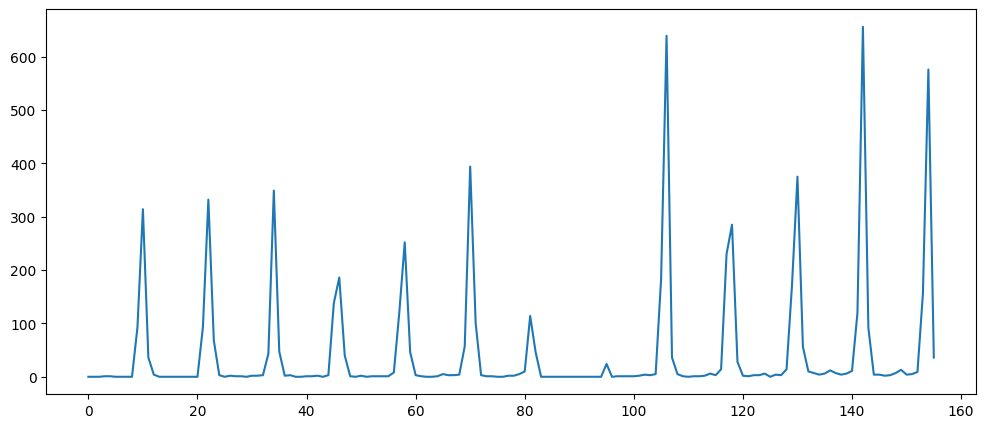

In [ ]:
plt.figure(figsize=(12,5))
time = range(len(total_data))
plt.plot(time, total_data['감염자수'])

In [ ]:
total_data = total_data.astype('float64')
total_data.to_excel('data.xlsx',index=None)
total_data.columns

Index(['연도', '월', '감염자수', '평균기온', '평균최고기온', '평균최저기온', '평균상대습도', '최소상대습도',
       '월합강수량'],
      dtype='object')

In [ ]:
features = ['평균기온', '평균최고기온', '평균최저기온', '평균상대습도', '최소상대습도',
       '월합강수량']
X = total_data.loc[:, features]
Y = total_data[['감염자수']]

In [ ]:
X_max = X.max()
Y_max = Y.max()

X_min = X.min()
Y_min = Y.min()

X_s = (X-X_min)/(X_max-X_min)
Y_s = (Y-Y_min)/(Y_max-Y_min)

In [ ]:
window_size = 3

In [ ]:
def make_dataset(x_data, y_data, window_size):
  x_list = []
  y_list = []
  for i in range(len(x_data) - window_size):
    x_list.append(np.array(x_data.iloc[i:i+window_size]))
    y_list.append(np.array(y_data.iloc[i+window_size]))
  x_list = torch.Tensor(np.array(x_list))
  y_list = torch.Tensor(np.array(y_list)).view(-1)
  return x_list, y_list

In [ ]:
X_w, Y_w = make_dataset(X_s, Y_s, window_size)

In [ ]:
start_year = 2005
pred_year = 2017

train_num = 12*(pred_year-start_year)-window_size

X_train = X_w[:train_num].to(device)
X_test = X_w[train_num:].to(device)

y_train = Y_w[:train_num].to(device)
y_test = Y_w[train_num:].to(device)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=16)

for x_data, y_data in train_loader:
  break
print(x_data.shape)
print(y_data.shape)

torch.Size([16, 3, 6])
torch.Size([16])


In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size = len(features), hidden_size=16, num_layers=5,
                          batch_first = True)

        self.fc1 = nn.Linear(in_features=window_size*16, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(5, x.shape[0], 16).to(device)
        x, hn = self.rnn(x, h0)

        x = x.reshape(x.size(0),-1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = x.reshape(-1)

        return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(42)

model = RNN()
model.to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_train_record=[]
loss_test_record=[]

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):

  for x_data, y_data in train_loader:
    optimizer.zero_grad()

    outputs = model(x_data)
    loss_train = nn.MSELoss()(outputs, y_data)

    loss_train.backward()
    optimizer.step()

  outputs_train = model(X_train)
  loss_train = nn.MSELoss()(outputs_train, y_train)

  outputs_test = model(X_test)
  loss_test = nn.MSELoss()(outputs_test, y_test)

  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())
  if epoch % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss_train:.5f}, loss_test: {loss_test:.5f}')

Epoch [1/1000], loss: 0.02668, loss_test: 0.06087
Epoch [101/1000], loss: 0.00606, loss_test: 0.01396
Epoch [201/1000], loss: 0.00290, loss_test: 0.01286
Epoch [301/1000], loss: 0.00091, loss_test: 0.02840
Epoch [401/1000], loss: 0.00069, loss_test: 0.02122
Epoch [501/1000], loss: 0.00138, loss_test: 0.03815
Epoch [601/1000], loss: 0.00046, loss_test: 0.02836
Epoch [701/1000], loss: 0.00028, loss_test: 0.03566
Epoch [801/1000], loss: 0.00009, loss_test: 0.04865
Epoch [901/1000], loss: 0.00004, loss_test: 0.04852


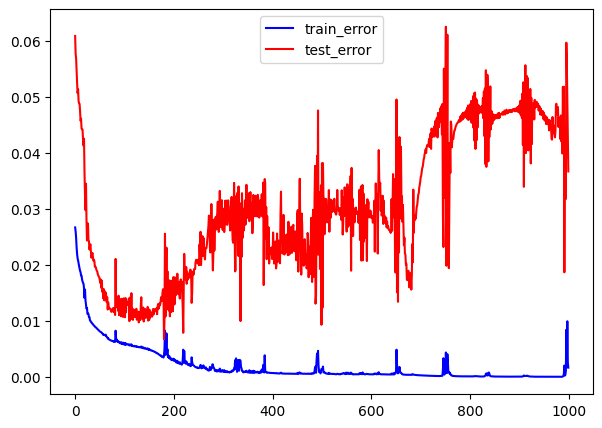

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(loss_train_record,'b',label='train_error')
plt.plot(loss_test_record,'r',label='test_error')
plt.legend()
plt.show()

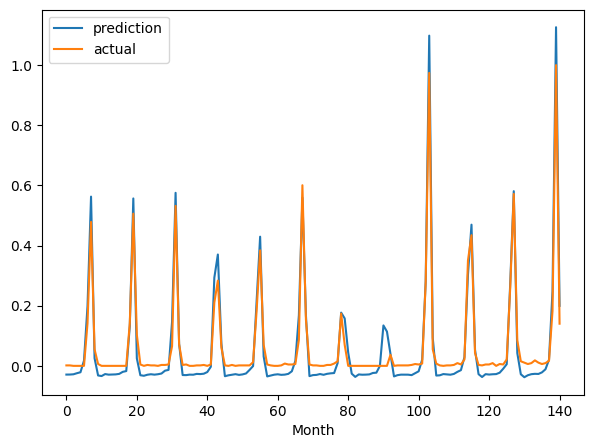

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(outputs_train.to('cpu').detach(), label='prediction')
plt.plot(y_train.to('cpu'), label = 'actual')
plt.xlabel('Month')
plt.legend()
plt.show()

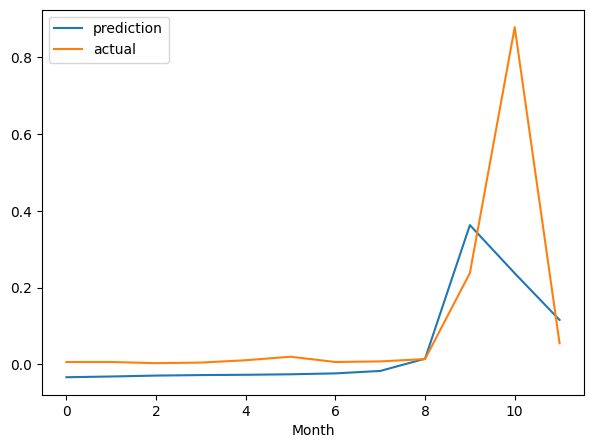

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(outputs_test.to('cpu').detach(), label='prediction')
plt.plot(y_test.to('cpu'), label = 'actual')
plt.xlabel('Month')
plt.legend()
plt.show()

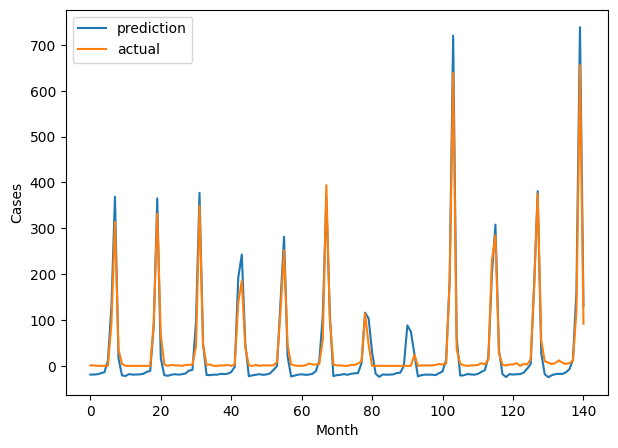

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(torch.Tensor([Y_max.item()-Y_min.item()])*outputs_train.to('cpu').detach()+torch.Tensor([Y_min.item()]), label='prediction')
plt.plot(torch.Tensor([Y_max.item()-Y_min.item()])*y_train.to('cpu')+torch.Tensor([Y_min.item()]), label = 'actual')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend()
plt.show()

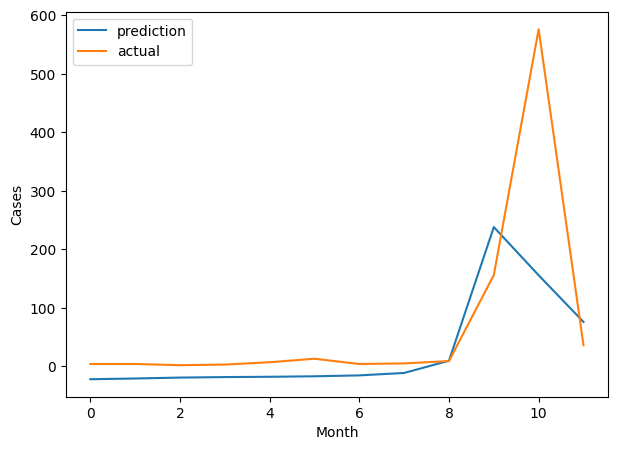

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(torch.Tensor([Y_max.item()-Y_min.item()])*outputs_test.to('cpu').detach()+torch.Tensor([Y_min.item()]), label='prediction')
plt.plot(torch.Tensor([Y_max.item()-Y_min.item()])*y_test.to('cpu')+torch.Tensor([Y_min.item()]), label = 'actual')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend()
plt.show()